<!--<div style=float:right><img src="assets/img/applied-logo_100px.png"></img></div>-->

#### Applied AI Internal Demo Project
## Survival Analysis HDD

Demo some capabilities of parametric and nonparametric survival analysis using Python tools.  
Using hard drive survival data from the [BackBlaze HDD tests](https://www.backblaze.com/blog/hard-drive-data-feb2015/)


# 03_KaplanMeierModel

+ [Setup](#Setup)
    + [Local Functions](#Local-Functions)
    + [Load Data](#Load-Data)
    
    
+ [Kaplan Meier Modeling](#Kaplan-Meier-Modeling)
    + [Overall Lifetime](#Overall-Lifetime)
    + [Lifetime by Manufacturer](#Lifetime-by-Manufacturer)
    + [Lifetime by Manufacturer by Capacity](#Lifetime-by-Manufacturer-by-Capacity)    


# Setup

In [1]:
## Interactive magics - comment out if running from another script
%matplotlib inline
%qtconsole --colors=linux --ConsoleWidget.font_size=12 --ConsoleWidget.font_family='Consolas'

In [119]:
from collections import OrderedDict
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import lifelines as sa

# suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Set default styles for plotting via pandas, seaborn and matplotlib
pd.set_option('display.mpl_style', 'default')
pd.set_option('display.notebook_repr_html', True)
sns.set(style='darkgrid')
cmap_clrbld = ['#777777','#E69F00','#56B4E9','#D3C511'
               ,'#009E73','#8D42F0','#0072B2','#D55E00','#CC79A7']
plt.rcParams['axes.color_cycle'] = cmap_clrbld
plt.rcParams['figure.figsize'] = 14, 6

np.random.seed(0)

## Local Functions

In [77]:
def estimate_cond_mean(S):
    """ Quick & dirty estimate of conditional mean lifetime """
    fstar = -S.diff() / (1-S.iloc[-1,0])
    Sstar = (S-S.iloc[-1,0]) / (1-S.iloc[-1,0])
    llstar = fstar / Sstar
  
    llstar[pd.isnull(llstar)] = 0
    llstar = llstar[np.isfinite(llstar)]
    llstarcs = llstar.cumsum().reset_index()
    llstarcs['timelinediff'] = np.append(llstarcs['timeline'].diff().values[1:],0)
    llstarcs['auc'] = llstarcs['timelinediff'] * llstarcs['KM_estimate']
    return np.nansum(llstarcs['auc']).round()


def plot_km(km, axes, suptxt='', subtxt='', i=0, j=0, arws=[], xmax=0, smlfs=10):

    ax = km.plot(ax=axes[i,j], title=subtxt, legend=False)
    plt.suptitle(suptxt, fontsize=14)
    axes[i,j].axhline(0.5, ls='--', lw=0.5)
    axes[i,j].annotate('half-life', fontsize=smlfs, color='b'
            ,xy=(0,0.5), xycoords='axes fraction'
            ,xytext=(10,4), textcoords='offset points')

    S = km.survival_function_
    hl = S.loc[S['KM_estimate']<0.5,'KM_estimate'].head(1)
    if len(hl) == 1:
        axes[i,j].annotate('{:.0f}'.format(hl.index[0]), fontsize=smlfs
            ,xy=(0,0.5), xycoords='axes fraction'
            ,xytext=(10,-12), textcoords='offset points', color='b')

    for pt in arws:
        tml = km.survival_function_[:pt].tail(1)
        plt.annotate('{:.1%}\n@ {:.0f}hrs'.format(tml['KM_estimate'].values[0],tml.index.values[0])
                ,xy=(tml.index.values,tml['KM_estimate'].values), xycoords='data'
                ,xytext=(6,-50), textcoords='offset points', color='#007777', fontsize=smlfs
                ,arrowprops={'facecolor':'#007777', 'width':2})

    ax.set_ylim([0,1])
    ax.set_xlim([0,xmax])

## Load Data

In [19]:
cnx = sqlite3.connect('data/drive_stats.db')
df = pd.read_sql('select * from drive_survival_prepared', con=cnx
                 ,index_col='diskid', parse_dates=['mindate','maxdate'])

In [20]:
print(df.shape)
df.head()

(47252, 11)


,model,mindate,maxdate,nrecords,minhours,maxhours,failed,manufacturer,capacity,mindateym,maxdateym
diskid,,,,,,,,,,,
5XW004AJ,ST31500541AS,2013-04-20,2014-12-31,564,21697,36586,0,SEAGATE,1.5TB,201304,201412
5XW004Q0,ST31500541AS,2013-04-10,2014-12-31,574,29341,44471,0,SEAGATE,1.5TB,201304,201412
5XW008MX,ST31500541AS,2013-04-10,2014-12-31,574,29341,44471,0,SEAGATE,1.5TB,201304,201412
5XW00B95,ST31500541AS,2013-04-10,2014-12-31,574,26920,42049,0,SEAGATE,1.5TB,201304,201412
5XW00E5M,ST32000542AS,2013-05-16,2014-07-31,386,22036,32614,0,SEAGATE,2.0TB,201305,201407


---

# Kaplan Meier Modelling

### Overall Lifetime

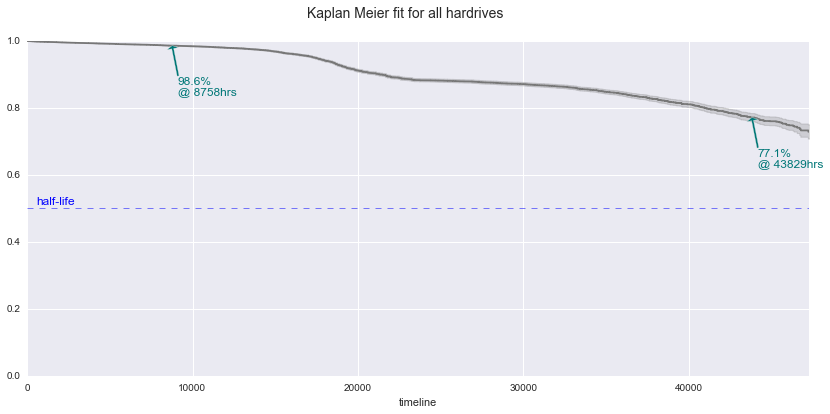

In [80]:
fig, axes = plt.subplots(nrows=1, ncols=1
                         ,squeeze=False, sharex=True, sharey=True)
km = sa.KaplanMeierFitter()
km.fit(durations=df['maxhours'], event_observed=df['failed'])
plot_km(km, axes, xmax=df.shape[0], arws=[8760, 43830]
        ,suptxt='Kaplan Meier fit for all hardrives', smlfs=12)

**Observe:**  
+ The hardrives survive well throughout our study period: we don't even get to measure a halflife, since by the end of the timeline more then half the harddrives remain.
+ At approx 1 year (8,760 hours) of continuous uptime aka 'power-on hours' we see 98.6% of drives remain active
+ Stated another way, we can expect approx 1.4% of our harddrives to fail during their first year of power-on time
+ At approx 5 years (43,830 hours) we see 77.1% of drives are still running, or another way, after 5 years we can expect 23% of our drives to have failure.

##### Estimated mean lifetime

It's not guaranteed that a harddrive will fail, so the mean estimated lifetime using our study is undefined. We can however, calculate a conditional mean estimated lifetime - where the condition is that the drive must fail.

In [23]:
estimate_cond_mean(km.survival_function_)

29908.0

**Observe:**  
+ We find a conditional mean-estimated lifetime of 29908 hours / 1246 days / approx 3.5 years.
+ So, with a large caveat that we're limited by the duration of the study, we might say that a harddrive is going to fail, it will do so with a mean lifetime of 3.5 years.
+ Crucially though, we can't say _which_ particular drives will fail, and the variance covers the entire period, so drives may still fail after even 1 hour.

### Lifetime by Manufacturer

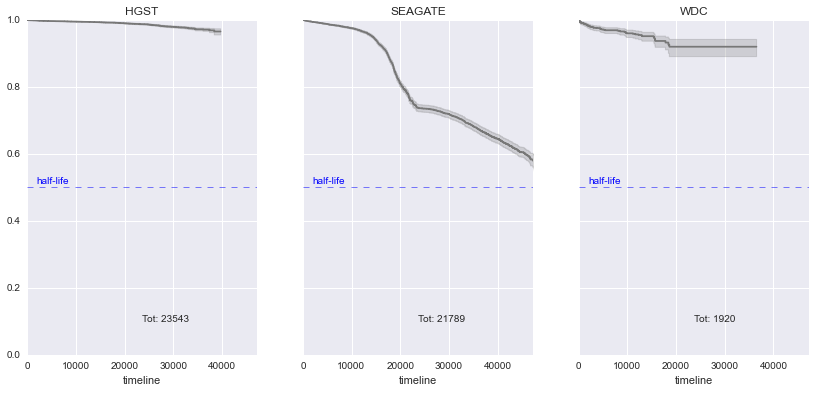

In [81]:
fig, axes = plt.subplots(nrows=1, ncols=len(df['manufacturer'].value_counts())
                         ,squeeze=False, sharex=True, sharey=True)

for j, mfr in enumerate(np.unique(df['manufacturer'])):
    dfsub = df.loc[df['manufacturer']==mfr]
    km = sa.KaplanMeierFitter()
    km.fit(durations=dfsub['maxhours'], event_observed=dfsub['failed'])
    plot_km(km, axes, j=j, subtxt=mfr, xmax=df.shape[0])
    axes[0,j].annotate('Tot: {}'.format(dfsub.shape[0]), xy=(0.5,0.1), xycoords='axes fraction')

**Observe:**
+ Here we see again that Seagate drives in general have a much shorter time to failure than HGST and WDC
    + We see the large drop around 20,000 hours, after this only 80% remain
    + After 5 years of 'power-on' we see only 60% remain
+ We also see that Seagate drives have been in usage for a longer time at Backblaze

### Lifetime by Manufacturer by Capacity

Let's add harddrive capacity into the analysis to really try to isolate the poorly performing models 

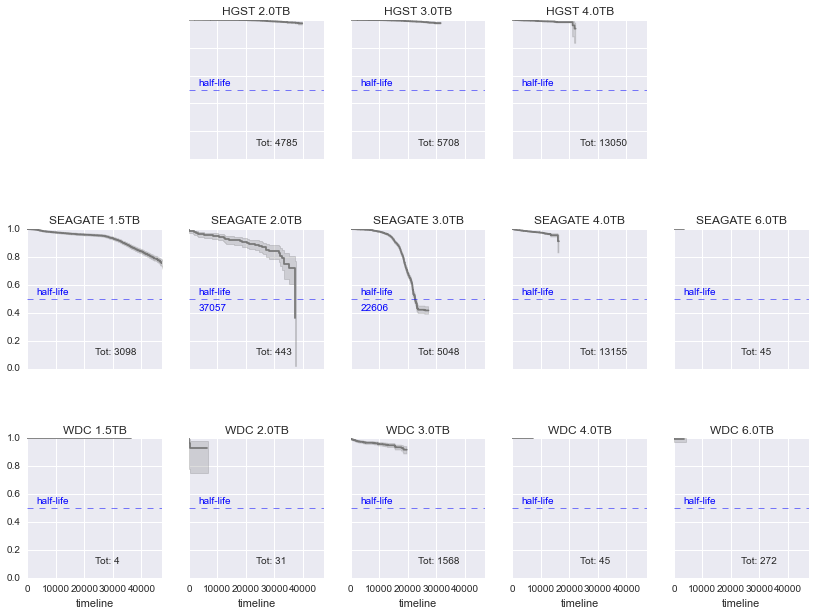

In [82]:
fig, axes = plt.subplots(nrows=len(df['manufacturer'].value_counts())
                         ,ncols=len(df['capacity'].value_counts())
                         ,squeeze=False, sharex=True, sharey=True, figsize=(14,10))

for i, mfr in enumerate(np.unique(df['manufacturer'])):
    for j, cap in enumerate(np.unique(df['capacity'])):
        dfsub = df.loc[(df['manufacturer']==mfr) & (df['capacity']==cap)]
        if dfsub.shape[0]!=0:
            km = sa.KaplanMeierFitter()
            km.fit(durations=dfsub['maxhours'], event_observed=dfsub['failed'])
            plot_km(km, axes, i=i, j=j, subtxt='{} {}'.format(mfr, cap), xmax=df.shape[0])
            axes[i,j].annotate('Tot: {}'.format(dfsub.shape[0]), xy=(0.5,0.1), xycoords='axes fraction')
        else:
            axes[i,j].axis('off')


**Observe:**
+ 1.5TB drives have been in longest use at BackBlaze, which makes sense since they're older products. 
    + After 5 years approx 20% of Seagate drives have failed
    + Only 4 drives from WDC are this size, but they perform well and appear not to fail.
+ 4TB & 6TB drives appear to be quite resilient throughout all manufacturers
+ 2TB & 3TB drives show many issues, particularly Seagate drives, which have a measured half-life around 37k & 23k hours respectively (4.2 years & 2.6 years)

##### Let's focus on 3TB harddrives for a minute:

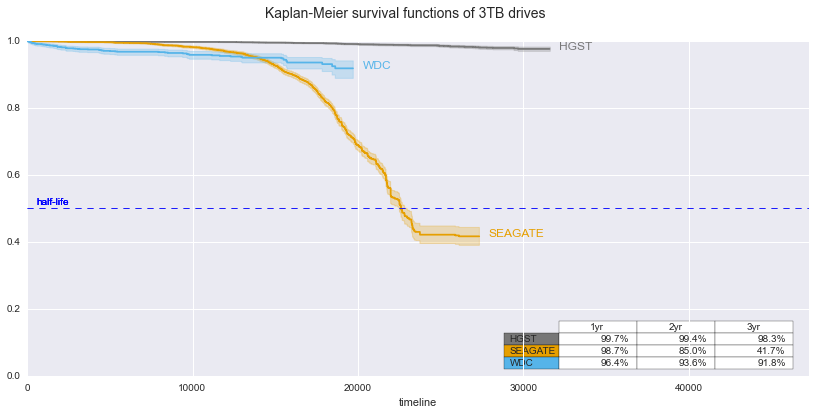

In [180]:
dd = OrderedDict()
fig, axes = plt.subplots(nrows=1, ncols=1, squeeze=False, sharex=True, sharey=True)
fig.suptitle('Kaplan-Meier survival functions of 3TB drives', fontsize=14)

for j, mfr in enumerate(np.unique(df['manufacturer'])):
    dd[mfr] = {8760:'', 17520:'', 26280:''}
    dfsub = df.loc[(df['manufacturer']==mfr) & (df['capacity']=='3.0TB')]
    km = sa.KaplanMeierFitter()
    km.fit(durations=dfsub['maxhours'], event_observed=dfsub['failed'])
    ax = km.plot(ax=axes[0,0], legend=False)
    axes[0,0].axhline(0.5, ls='--', lw=0.5)
    axes[0,0].annotate('half-life', xy=(0,0.5), xycoords='axes fraction'
                ,xytext=(10,4), textcoords='offset points', color='b', fontsize=10)
    fnlS = km.survival_function_.iloc[-1:,:]
    axes[0,0].annotate('{}'.format(mfr), xy=(fnlS.index.values[0],fnlS.values[0][0])
                       ,xycoords='data', color=cmap_clrbld[j], fontsize=12
                       ,xytext=(10,0), textcoords='offset points')
    for pt in dd[mfr].keys():
        tml = km.survival_function_[:int(pt)].tail(1)
        dd[mfr][pt] = tml.values[0][0]

    ax.set_ylim([0,1])
    ax.set_xlim([0,df.shape[0]])

tbl = plt.table(cellText=pd.DataFrame(dd).T.applymap(lambda x: '{:.1%}'.format(x)).as_matrix()
                ,loc=('lower right'), colWidths=[0.1]*3
                ,rowLabels=pd.DataFrame(dd).T.index, colLabels=['1yr','2yr','3yr']
                ,rowColours=cmap_clrbld[:3])
    

**Observe:**
+ HGST 3TB drives appear to have far fewer failures than the rest - thoughout the whole study
+ At the 1 year mark, WDC drives perform the worst, with 3.6% of drives experiencing failure
+ However at the 2 year mark, Seagate drives have begun to nosedive, with 15% failure
+ At the 3 yr mark only 58% of Seagate 3TB drives have failed, whereas only 2% of HGST have failed.

---
<!--<div style=float:right><img src=assets/img/applied-logo_100px.png></img></div>-->
**&copy; Applied AI Ltd 2015**  
<a href='http://www.applied.ai'>applied.ai</a>